# Implementation of Softmax Regression from Scratch
:label:`chapter_softmax_scratch`

Linear regression을 해본 것처럼 multiclass logistic(softmax)도 해보자  
우선 import부터

In [3]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
import torch
from torch.distributions import normal

C:\Users\kyc_o\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kyc_o\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\kyc_o\anaconda3\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initialize Model Parameters
※ 이미지가 28 x 28 px였던 것을 상기합시다.  
우리는 각 example을 $784$차원 벡터로 처리할 수 있다.  
  
dataset에 10개의 카테고리가 있기 때문에, 우리의 망은 10차원의 output을 얻게될 것이다.  
결과적으로 weight는 $784 \times 10$ 행렬이 되고 bias는 $1 \times 10$ 벡터로 구성될 것이다.  
linear regression에서처럼 우리는 weight를 $W$로 초기화하고 Gaussian noise와 bias를 초기 값 $0$으로 설정한다.

In [5]:
num_inputs = 784
num_outputs = 10

W = normal.Normal(loc = 0, scale = 0.01).sample((num_inputs, num_outputs))
b = torch.zeros(num_outputs)

In [6]:
W.requires_grad_(True)
b.requires_grad_(True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

Gradient를 model parameter에 붙여주었다.

## The Softmax
※※※ `torch.sum`이 어떤식으로 동작하는지 review합시다.

In [7]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
torch.sum(X, dim = 0, keepdim=True), torch.sum(X, dim = 1, keepdim=True)

(tensor([[5, 7, 9]]),
 tensor([[ 6],
         [15]]))

이제 softmax 함수를 implement할 수 있다.
$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(X_{ij})}{\sum_k \exp(X_{ik})}
$$

In [8]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = torch.sum(X_exp, dim = 1, keepdim = True)
    return X_exp / partition

In [9]:
X = normal.Normal(loc = 0, scale = 1).sample((2, 5))
X_prob = softmax(X)
X_prob, torch.sum(X_prob, dim=1)

(tensor([[0.2242, 0.1242, 0.5410, 0.0247, 0.0858],
         [0.0708, 0.1225, 0.3247, 0.0767, 0.4052]]),
 tensor([1., 1.]))

어떤 random input이든 각 element를 non-negative number로 변환한다.
또한 각 행은 합해 1이 된다.(확률)

## The Model
이제 softmax regression model을 implement해보자.

In [10]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

In [15]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.tensor([0, 2])
torch.gather(y_hat, 1, y.unsqueeze(dim = 1))

tensor([[0.1000],
        [0.5000]])

In [16]:
def cross_entropy(y_hat, y):
    return -torch.gather(y_hat, 1, y.unsqueeze(dim = 1)).log()

## Classification Accuracy
예측 확률 분포`y_hat`를 통해, 우리는 가장 높은 확률의 class를 선택한다.
예측들이 실제 카테고리 `y`와 일치한다면 예측은 옳다. 예측이 옳게 된 비율이 classification accuracy이고 우린 이것을 직접 최적화할 순 없지만 performance metric으로 사용된다.  
  
정확도를 계산하기 위해서 먼저 예측된 class들을 살펴보기 위해 `y_hat.argmax(dim=1)`을 실행한다. 결과는 변수 `y`와 같은 형태를 갖고, 두 가지가 얼마나 자주 일치하는지를 체크하면 된다.

In [17]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim = 1) == y).float().mean().item()

In [18]:
accuracy(y_hat, y)

0.5

비슷하게 모델 `net`도 평가해보자

In [19]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum +=(net(X).argmax(dim = 1) == y).sum().item()
        n += y.size()[0]  #y.size()[0] = batch_size
    return acc_sum / n

In [20]:
evaluate_accuracy(test_iter, net)

0.1619

## Model Training
Number of epochs(`num_epochs`), learning rate(`lr`)은 둘 다 조정 가능한 hyper-parameter이다. 조절해서 모델의 분류 정확도를 높일 수 있겠다.

In [22]:
num_epochs, lr = 5, 0.1

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params = None, lr = None, trainer = None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim = 1) == y).sum().item()
            n += y.size()[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
            % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.5710, train acc 0.812, test acc 0.810
epoch 2, loss 0.5266, train acc 0.826, test acc 0.814
epoch 3, loss 0.5015, train acc 0.832, test acc 0.819
epoch 4, loss 0.4855, train acc 0.835, test acc 0.824
epoch 5, loss 0.4742, train acc 0.839, test acc 0.822


## Prediction
학습이 끝났으니 우리의 모델은 몇 이미지를 분류할 준비가 되었다.

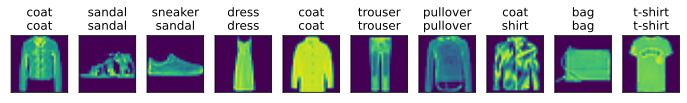

In [23]:
for X, y in test_iter:
    break
    
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim = 1).numpy())
titles = [truelabel + '\n' + predlabel for truelabel, predlabel in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[10:20], titles[10:20])

## Summary
Softmax regression을 이용하여 multi-category 분류를 위한 모델을 학습시킬 수 있다.  
Training loop은 linear regression의 그것과 아주 비슷하다.  
흔한 딥러닝 모델들은 비슷한 학습 절차를 밟는다!